In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_conf_mat 
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier

import warnings
import os 
import time

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# reading the data
df = pd.read_csv("data/train_data.csv")

In [3]:
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   TEXT       3321 non-null   object
dtypes: int64(2), object(3)
memory usage: 129.9+ KB


In [5]:
# splitting into train, test and validation sets
df.Gene = df.Gene.str.replace('\s+', '_')
df.Variation = df.Variation.str.replace('\s+', '_')
X = df.drop(['Class'], axis=1)
y = df['Class'].values

In [6]:
X.shape, y.shape

((3321, 4), (3321,))

In [7]:
# getting the test and train df:
train_x, X_test, train_y, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# getting the train and validation df:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, stratify = train_y, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(2124, 4) (2124,)
(532, 4) (532,)
(665, 4) (665,)


#### Data Preparation

In [9]:
# OneHot Encoding all features

In [10]:
# Gene Feature
gene_vectorizer = CountVectorizer()
train_gene_onehot = gene_vectorizer.fit_transform(X_train['Gene'])
valid_gene_onehot = gene_vectorizer.transform(X_valid['Gene'])
test_gene_onehot = gene_vectorizer.transform(X_test['Gene'])

In [11]:
train_gene_onehot.shape, valid_gene_onehot.shape, test_gene_onehot.shape

((2124, 236), (532, 236), (665, 236))

In [12]:
# Variation vectorizer
var_vectorizer = CountVectorizer()
train_var_onehot = var_vectorizer.fit_transform(X_train['Variation'])
valid_var_onehot = var_vectorizer.transform(X_valid['Variation'])
test_var_onehot = var_vectorizer.transform(X_test['Variation'])

In [13]:
train_var_onehot.shape, valid_var_onehot.shape, test_var_onehot.shape

((2124, 1952), (532, 1952), (665, 1952))

In [14]:
# TEXT vectorizer
text_vectorizer = CountVectorizer(min_df=3)
train_text_onehot = text_vectorizer.fit_transform(X_train['TEXT'])
valid_text_onehot = text_vectorizer.transform(X_valid['TEXT'])
test_text_onehot = text_vectorizer.transform(X_test['TEXT'])

# normalizing the features
train_text_onehot = normalize(train_text_onehot, axis=0)
valid_text_onehot = normalize(valid_text_onehot, axis=0)
test_text_onehot = normalize(test_text_onehot, axis=0)

In [15]:
train_text_onehot.shape, valid_text_onehot.shape, test_text_onehot.shape

((2124, 53295), (532, 53295), (665, 53295))

In [16]:
# Stacking / Merging all the features together

X_train_onehot = np.hstack((train_gene_onehot.toarray(), train_var_onehot.toarray(), train_text_onehot.toarray()))
X_valid_onehot = np.hstack((valid_gene_onehot.toarray(), valid_var_onehot.toarray(), valid_text_onehot.toarray()))
X_test_onehot = np.hstack((test_gene_onehot.toarray(), test_var_onehot.toarray(), test_text_onehot.toarray()))

In [17]:
X_train_onehot.shape, X_valid_onehot.shape, X_test_onehot.shape

((2124, 55483), (532, 55483), (665, 55483))

### Naive Bayes - Base Line Model

In [104]:
# hyperparameter tuning
alphas = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
val_logloss_error = []

for alpha in alphas:
    print(f"For Alpha = {alpha}")
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train_onehot, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_onehot, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_valid_onehot)
    
    # adding the loss to the list
    val_logloss_error.append(log_loss(y_valid, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print(f"Log Loss: {log_loss(y_valid, sig_clf_probs, labels=clf.classes_)}")

For Alpha = 1e-05
Log Loss: 1.2807541569914733
For Alpha = 0.0001
Log Loss: 1.278664751919148
For Alpha = 0.001
Log Loss: 1.263390138331115
For Alpha = 0.1
Log Loss: 1.2577638557132673
For Alpha = 1
Log Loss: 1.2662806431204658
For Alpha = 10
Log Loss: 1.3625148230085389
For Alpha = 100
Log Loss: 1.3729468880256575
For Alpha = 1000
Log Loss: 1.3216104270927778


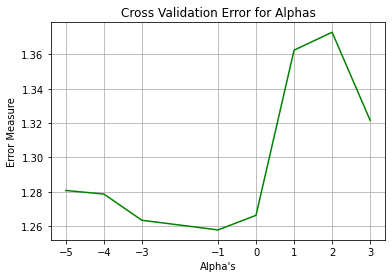

In [108]:
# plotting the results
fig, ax = plt.subplots()
ax.plot(np.log10(alphas), val_logloss_error, c='g')
plt.grid()
plt.xticks(np.log10(alphas))
plt.title("Cross Validation Error for Alphas")
plt.xlabel("Alpha's")
plt.ylabel("Error Measure")
plt.show();

In [111]:
# Model with best Alpha value
best_alpha = alphas[np.argmin(val_logloss_error)]
print(f"Best Alpha value = {best_alpha} : ")
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_train_onehot, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_onehot, y_train)

# predictions:
y_preds = sig_clf.predict_proba(X_train_onehot)
print(f"Train Loss: {log_loss(y_train, y_preds, labels=clf.classes_, eps=1e-15)}")
y_preds = sig_clf.predict_proba(X_valid_onehot)
print(f"Validation Loss: {log_loss(y_valid, y_preds, labels=clf.classes_, eps=1e-15)}")
y_preds = sig_clf.predict_proba(X_test_onehot)
print(f"Test Loss: {log_loss(y_test, y_preds, labels=clf.classes_, eps=1e-15)}")

Best Alpha value = 0.1 : 
Train Loss: 0.8484447180268448
Validation Loss: 1.2577638557132673
Test Loss: 1.3645239354177925


CONFUSION MATRIX


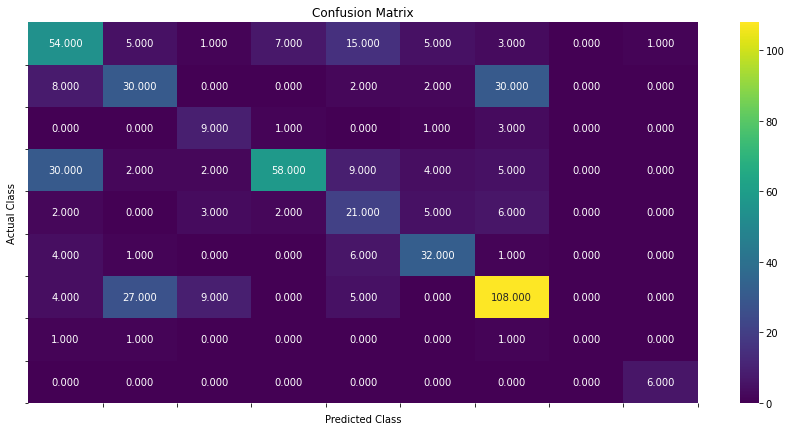

------------------------------------------------------------------------------------------------------------------------
PRECISION MATRIX


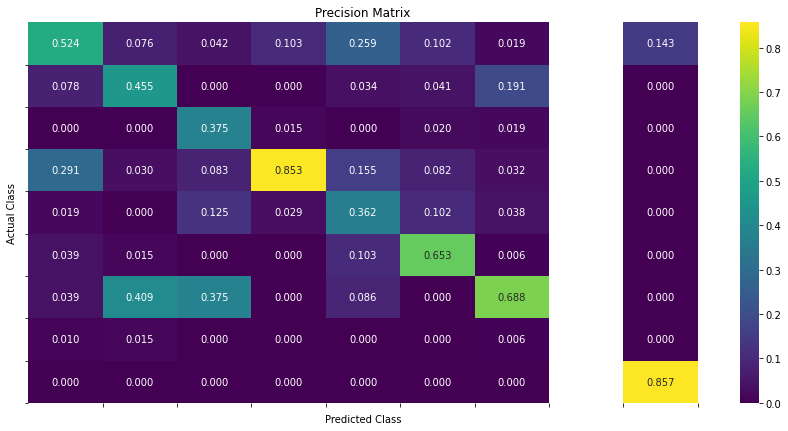

------------------------------------------------------------------------------------------------------------------------
RECALL MATRIX


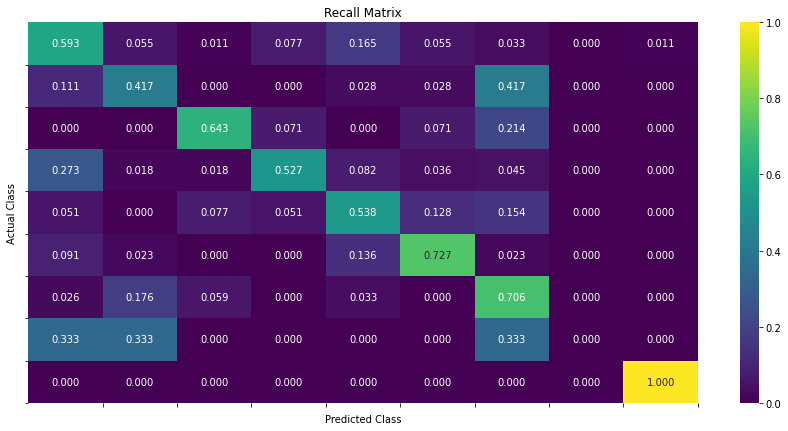

In [118]:
# plotting confusion matrix
plot_conf_mat(y_valid, sig_clf.predict(X_valid_onehot), labels=list(range(1, 10)))

***Checking some samples***

In [146]:
test_point_index = np.random.choice(X_test_onehot.shape[0])

predicted_class = sig_clf.predict(X_test_onehot[test_point_index].reshape(1, -1))
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Class Probabilities: {np.round(sig_clf.predict_proba(X_test_onehot[test_point_index].reshape(1, -1)), 4)}")
print(f"Actual Class: {y_test[test_point_index]}")

Predicted Class: [6]
Predicted Class Probabilities: [[0.0784 0.0723 0.0131 0.1025 0.0317 0.561  0.1321 0.0045 0.0044]]
Actual Class: 6


In [147]:
test_point_index = np.random.choice(X_test_onehot.shape[0])

predicted_class = sig_clf.predict(X_test_onehot[test_point_index].reshape(1, -1))
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Class Probabilities: {np.round(sig_clf.predict_proba(X_test_onehot[test_point_index].reshape(1, -1)), 4)}")
print(f"Actual Class: {y_test[test_point_index]}")

Predicted Class: [5]
Predicted Class Probabilities: [[0.092  0.0841 0.0152 0.1202 0.2819 0.0463 0.1548 0.0052 0.2002]]
Actual Class: 4


### Logistic Regression

In [20]:
# logreg model, with default hyperparameters:
logreg = LogisticRegression()

In [21]:
logreg.fit(X_train_onehot, y_train)

LogisticRegression()

In [25]:
# predicting the results on the validation set and test set:
y_pred_cv = logreg.predict_proba(X_valid_onehot)
y_pred_test = logreg.predict_proba(X_test_onehot)

In [26]:
# log loss:
ll_valid = log_loss(y_valid, y_pred_cv, labels=logreg.classes_, eps=1e-15)
print(f"Log Loss for default Logistic Regression on Validation Set: {ll_valid}")
ll_test = log_loss(y_test, y_pred_test, labels=logreg.classes_, eps=1e-15)
print(f"Log Loss for default Logistic Regression on Test Set: {ll_test}")

Log Loss for default Logistic Regression on Validation Set: 1.2810643634406753
Log Loss for default Logistic Regression on Test Set: 1.4504317883413682


In [35]:
# hyperparameter tuning 
param_grid = {
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag'],
    'C': np.logspace(-3, 3, 7)
}

model = LogisticRegression()
logreg_cv = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=4, n_jobs=-1, error_score='raise')
result = logreg_cv.fit(X_train_onehot, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [36]:
# best model:
print(result.best_score_)
print(result.best_estimator_)
print(result.best_estimator_)

0.6614861265260822
LogisticRegression(C=1000.0)
LogisticRegression(C=1000.0)


In [37]:
# creating the model and testing the results:
clf = result.best_estimator_
# sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
# sig_clf.fit(X_train_onehot, y_train)

y_preds = clf.predict_proba(X_train_onehot)
print("Train Loss:", log_loss(y_train, y_preds, labels=clf.classes_, eps=1e-15))
y_preds = clf.predict_proba(X_valid_onehot)
print("Valid Loss:", log_loss(y_valid, y_preds, labels=clf.classes_, eps=1e-15))
y_preds = clf.predict_proba(X_test_onehot)
print("Test Loss:", log_loss(y_test, y_preds, labels=clf.classes_, eps=1e-15))

Train Loss: 0.0010616241754338321
Valid Loss: 2.961338889496327
Test Loss: 3.189512908449853


CONFUSION MATRIX


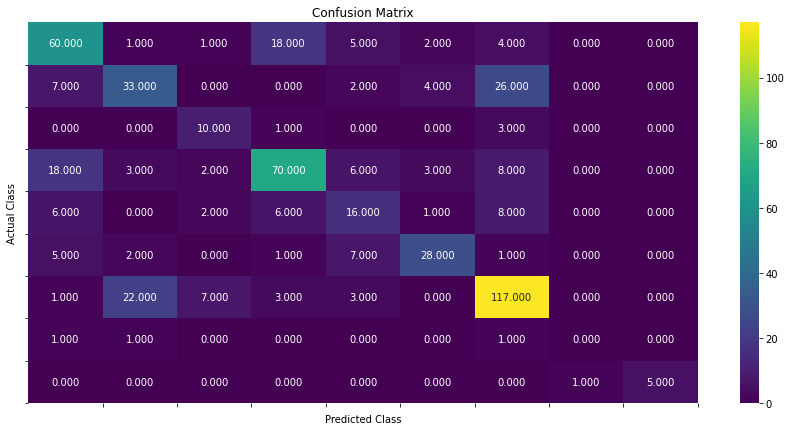

------------------------------------------------------------------------------------------------------------------------
PRECISION MATRIX


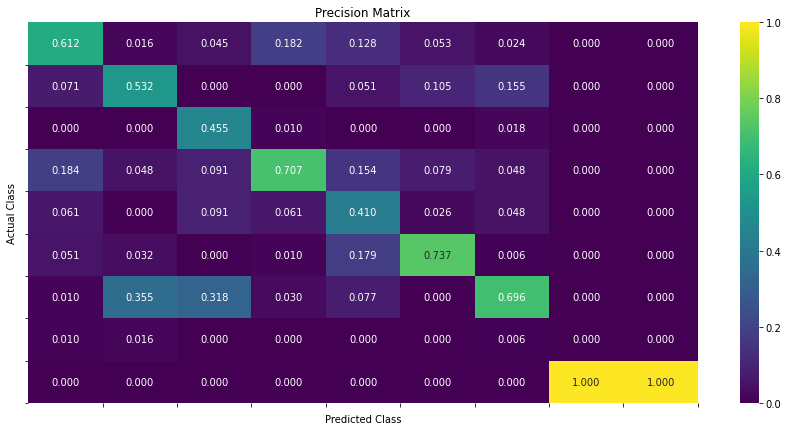

------------------------------------------------------------------------------------------------------------------------
RECALL MATRIX


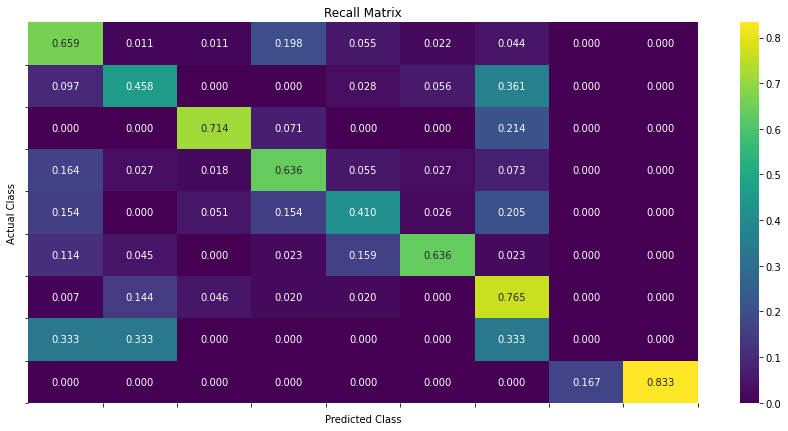

In [38]:
plot_conf_mat(y_valid, clf.predict(X_valid_onehot), labels=list(range(1, 10)))

In [42]:
# class balancing in Logistic Regression:
alphas = [10 ** x for x in range(-6, 3)]
val_logloss_error = []

for alpha in alphas:
    print(f"For Alpha: {alpha}")
    # class_weight = 'balanced' --> to balance the weight of the classes
    clf = SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_onehot, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_onehot, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_valid_onehot)
    
    error = log_loss(y_valid, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    val_logloss_error.append(error)
    print(f"Log Loss: {error}")

For Alpha: 1e-06
Log Loss: 1.2537051778520028
For Alpha: 1e-05
Log Loss: 1.2270028106080595
For Alpha: 0.0001
Log Loss: 1.0595063738186634
For Alpha: 0.001
Log Loss: 0.9983323948238032
For Alpha: 0.01
Log Loss: 1.0061118167103966
For Alpha: 0.1
Log Loss: 1.0909135952644964
For Alpha: 1
Log Loss: 1.2238471531647188
For Alpha: 10
Log Loss: 1.6224291840067637
For Alpha: 100
Log Loss: 1.7210852624866704


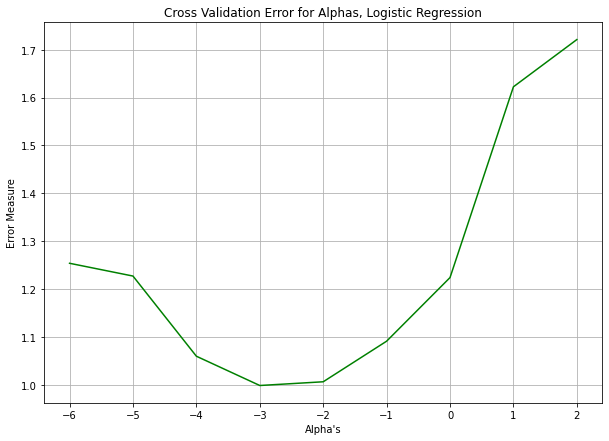

In [44]:
# plotting the results
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.log10(alphas), val_logloss_error, c='g')
plt.grid()
plt.xlabel('Alpha\'s')
plt.ylabel('Error Measure')
plt.title('Cross Validation Error for Alphas, Logistic Regression')
plt.show();

In [49]:
# best alpha value:
best_alpha = alphas[np.argmin(val_logloss_error)]
print("Best Alpha Value: ", best_alpha)

clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, loss='log', penalty='l2', random_state=42, n_jobs=-1)
clf.fit(X_train_onehot, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_onehot, y_train)

# predictions and score on Train, Validation and Test sets:
y_preds = sig_clf.predict_proba(X_train_onehot)
print(f"Train Loss: {log_loss(y_train, y_preds, labels=clf.classes_, eps=1e-15)}")
y_preds = sig_clf.predict_proba(X_valid_onehot)
print(f"Validation Loss: {log_loss(y_valid, y_preds, labels=clf.classes_, eps=1e-15)}")
y_preds = sig_clf.predict_proba(X_test_onehot)
print(f"Test Loss: {log_loss(y_test, y_preds, labels=clf.classes_, eps=1e-15)}")

Best Alpha Value:  0.001
Train Loss: 0.5112018042629316
Validation Loss: 0.9983323948238032
Test Loss: 1.1704059046672686


CONFUSION MATRIX


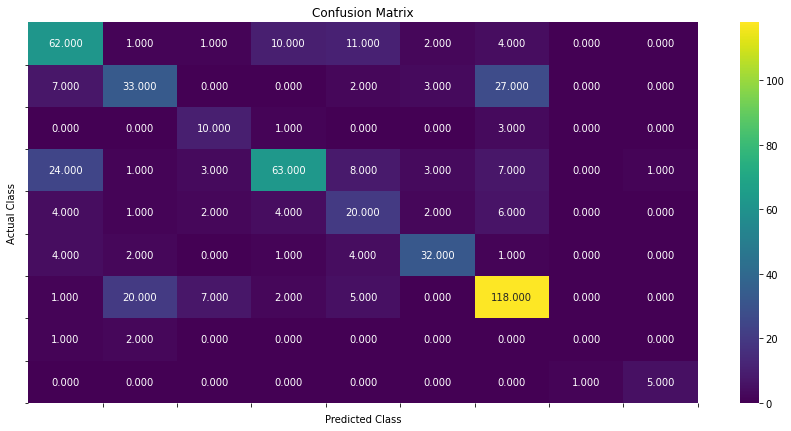

------------------------------------------------------------------------------------------------------------------------
PRECISION MATRIX


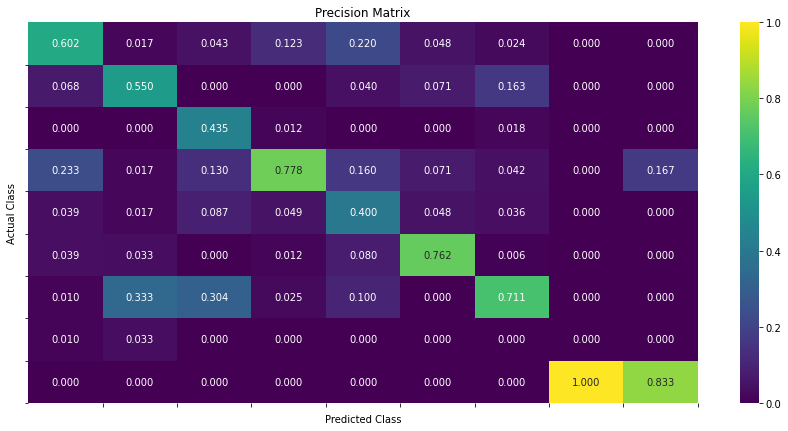

------------------------------------------------------------------------------------------------------------------------
RECALL MATRIX


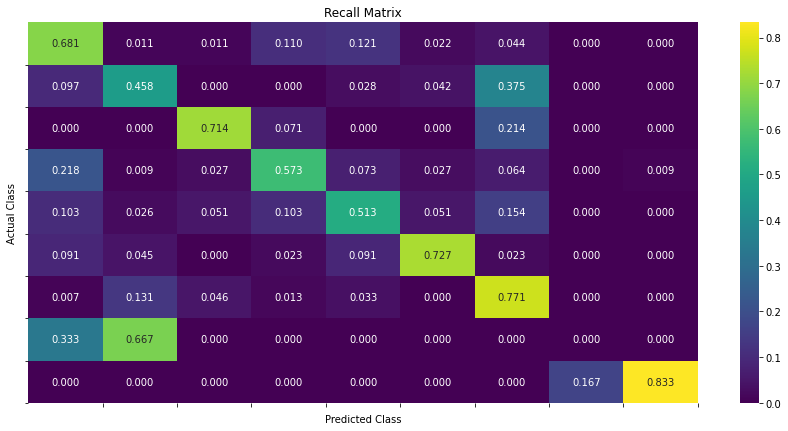

In [50]:
# plotting the confusion matrix:
plot_conf_mat(y_valid, clf.predict(X_valid_onehot), labels=list(range(1, 10)))

***Checking some Samples:***

In [61]:
test_point_index = np.random.choice(X_test_onehot.shape[0])
test_point = X_test_onehot[test_point_index]
print("Data Point:",test_point)

print(f"Test Point Index: {test_point_index}")
y_pred = sig_clf.predict(test_point.reshape(1, -1))
print(f"Predicted Class: {y_pred}")
print(f"Class Probabilities: {np.round(sig_clf.predict_proba(test_point.reshape(1, -1)), 4)}")
print(f"Actual Class: {y_test[test_point_index]}")

Data Point: [0. 0. 0. ... 0. 0. 0.]
Test Point Index: 206
Predicted Class: [7]
Class Probabilities: [[0.0048 0.0197 0.003  0.0041 0.0041 0.006  0.9497 0.005  0.0038]]
Actual Class: 7


In [63]:
test_point_index = np.random.choice(X_test_onehot.shape[0])
test_point = X_test_onehot[test_point_index]
print("Data Point:",test_point)

print(f"Test Point Index: {test_point_index}")
y_pred = sig_clf.predict(test_point.reshape(1, -1))
print(f"Predicted Class: {y_pred}")
print(f"Class Probabilities: {np.round(sig_clf.predict_proba(test_point.reshape(1, -1)), 4)}")
print(f"Actual Class: {y_test[test_point_index]}")

Data Point: [0. 0. 0. ... 0. 0. 0.]
Test Point Index: 384
Predicted Class: [7]
Class Probabilities: [[0.0153 0.2323 0.0045 0.0106 0.0159 0.011  0.7017 0.0044 0.0043]]
Actual Class: 2


### Support Vector Machines

In [21]:
# hyperparameter tuning 
alphas = [10 ** x for x in range(-5, 3)]
val_logloss_error = []

for alpha in alphas:
    print(f"For Alpha: {alpha}")
    # SGDClassifier with Hinge Loss == Support Vector Machine
    clf = SGDClassifier(class_weight='balanced', alpha=alpha, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_onehot, y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_onehot, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_valid_onehot)
    error = log_loss(y_valid, sig_clf_probs, labels=clf.classes_, eps=1e-15)
    
    val_logloss_error.append(error)
    print(f"Log Loss: {error}")

For Alpha: 1e-05
Log Loss: 1.2177037921070561
For Alpha: 0.0001
Log Loss: 1.1982812296325838
For Alpha: 0.001
Log Loss: 1.1165647801843013
For Alpha: 0.01
Log Loss: 1.1583765770812582
For Alpha: 0.1
Log Loss: 1.2131970070586848
For Alpha: 1
Log Loss: 1.2102301459456948
For Alpha: 10
Log Loss: 1.1707812290877753
For Alpha: 100
Log Loss: 1.7519502729251204


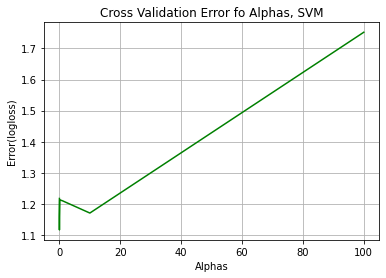

In [24]:
# plotting the results
fig, ax = plt.subplots()
ax.plot(alphas, val_logloss_error, c='g')
plt.title("Cross Validation Error fo Alphas, SVM")
plt.xlabel('Alphas')
plt.ylabel('Error(logloss)')
plt.grid()
plt.show();

In [25]:
# best alpha
best_alpha = alphas[np.argmin(val_logloss_error)]
print(f"Best Alpha value: {best_alpha}")

Best Alpha value: 0.001


In [26]:
# training the model with the best alpha value
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, loss='hinge', penalty='l2', random_state=42, n_jobs=-1)
clf.fit(X_train_onehot, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_onehot, y_train)

# predictions and logloss scores:
y_preds = sig_clf.predict_proba(X_train_onehot)
print(f"Train Loss: {log_loss(y_train, y_preds, labels=clf.classes_, eps=1e-15)}")
y_preds = sig_clf.predict_proba(X_valid_onehot)
print(f"Validation Loss: {log_loss(y_valid, y_preds, labels=clf.classes_, eps=1e-15)}")
y_preds = sig_clf.predict_proba(X_test_onehot)
print(f"Test Loss: {log_loss(y_test, y_preds, labels=clf.classes_, eps=1e-15)}")

Train Loss: 0.5206830325056052
Validation Loss: 1.1165647801843013
Test Loss: 1.2487398425927168


CONFUSION MATRIX


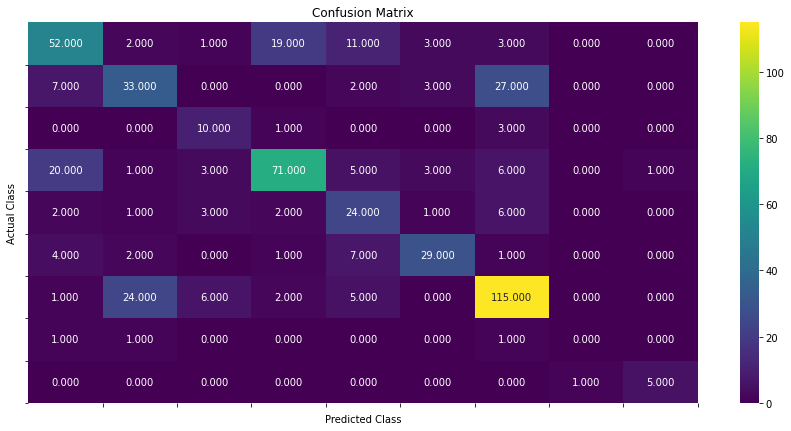

------------------------------------------------------------------------------------------------------------------------
PRECISION MATRIX


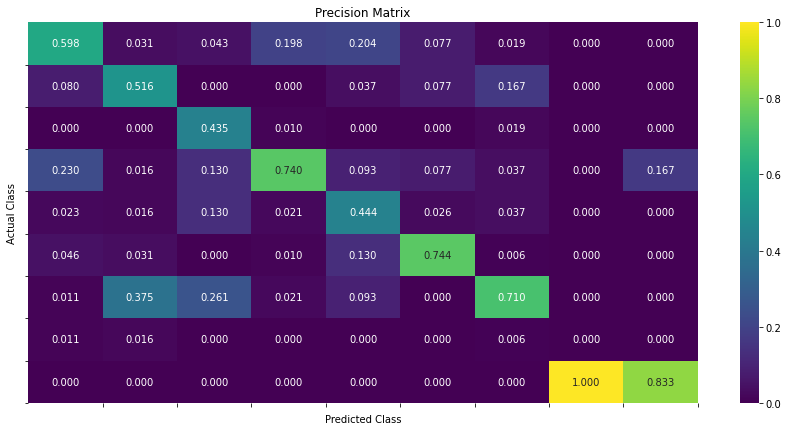

------------------------------------------------------------------------------------------------------------------------
RECALL MATRIX


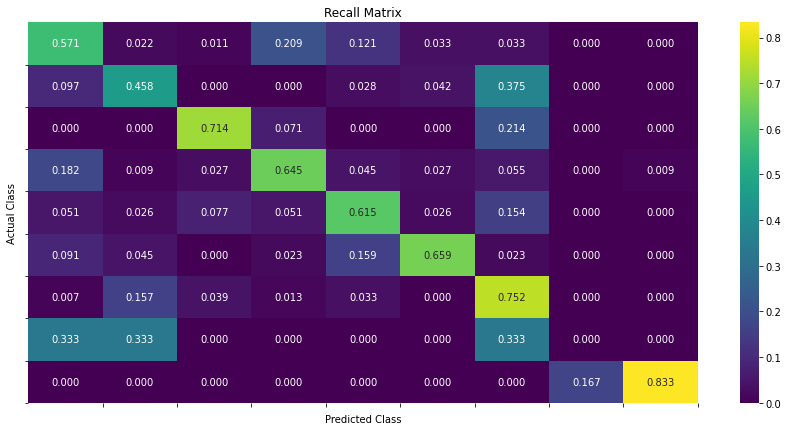

In [27]:
# plotting the confusion matrix
plot_conf_mat(y_valid, clf.predict(X_valid_onehot), labels=list(range(1, 10)))

***Checking some samples:***

In [41]:
test_point_index = np.random.choice(X_test_onehot.shape[0])
test_point = X_test_onehot[test_point_index]
print("Data Point:", test_point)
print("Test Point Index:", test_point_index)
y_pred = sig_clf.predict(test_point.reshape(1, -1))
print("Predicted Class:", y_pred)
print("Class Probabilities:", np.round(sig_clf.predict_proba(test_point.reshape(1, -1)), 4))
print("Actual Class:", y_test[test_point_index])

Data Point: [0. 0. 0. ... 0. 0. 0.]
Test Point Index: 602
Predicted Class: [4]
Class Probabilities: [[0.0689 0.0501 0.0182 0.5205 0.1914 0.0324 0.1056 0.0052 0.0077]]
Actual Class: 4


In [47]:
test_point_index = np.random.choice(X_test_onehot.shape[0])
test_point = X_test_onehot[test_point_index]
print("Data Point:", test_point)
print("Test Point Index:", test_point_index)
y_pred = sig_clf.predict(test_point.reshape(1, -1))
print("Predicted Class:", y_pred)
print("Class Probabilities:", np.round(sig_clf.predict_proba(test_point.reshape(1, -1)), 4))
print("Actual Class:", y_test[test_point_index])

Data Point: [0. 0. 0. ... 0. 0. 0.]
Test Point Index: 297
Predicted Class: [7]
Class Probabilities: [[0.0641 0.0312 0.0198 0.0515 0.0294 0.0254 0.7693 0.0044 0.0051]]
Actual Class: 3


### Random Forest

In [60]:
# hyperparameter tuning with GridSearchCV
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_depth = [int(x) for x in np.linspace(5, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# creating the grid
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

In [61]:
# building the model
model = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, error_score='raise')

# fitting the GridSearchCV to our data
grid_rf.fit(X_train_onehot, y_train)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  14.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  14.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  14.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=  20.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=  20.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=  20.9s
[CV] END max_depth=5, min_samples_l

[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=  56.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=  54.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=  52.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  58.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 1.0min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 1.0min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.2min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.1min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.1min
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200; t

[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  32.5s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  32.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  38.8s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  38.4s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=  38.6s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=  44.7s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=  44.9s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time=  45.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=  50.3s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1600;

[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  13.0s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  19.2s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  19.2s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  19.2s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  25.9s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  25.6s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  25.8s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  32.6s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  31.4s
[CV] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total 

[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 2.6min
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 2.7min
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 2.8min
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 2.8min
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  15.1s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  15.1s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  15.2s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  29.1s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  30.5s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=400;

[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 1.5min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 1.7min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 1.7min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 1.7min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 1.9min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 1.9min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.0min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.1min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.2min
[CV] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=1800;

[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  40.1s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  52.0s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  52.9s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  52.5s
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 1.3min
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 1.3min
[CV] END max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; tot

[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 6.7min
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  23.5s
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  23.7s
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  23.0s
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  45.5s
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  45.3s
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  45.2s
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.1min
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.2min
[CV] END max_depth=26, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total ti

[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.2min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.4min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.5min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.5min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 2.7min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 2.8min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 2.8min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.0min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.0min
[CV] END max_depth=26, min_samples_leaf=2, min_samples_split=2, n_estimators=2000;

[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  58.0s
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.2min
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.3min
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.3min
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.5min
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.5min
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.6min
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.8min
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.7min
[CV] END max_depth=26, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; 

[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  40.9s
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.3min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.5min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.4min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.0min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.2min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.0min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 2.7min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 2.9min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total tim

[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 2.4min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.6min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.8min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.7min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 3.0min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 3.1min
[CV] END max_depth=36, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 3.0min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  19.7s
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  20.7s
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=2, n_estimators=

[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 1.4min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.6min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.7min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.6min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.9min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.9min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.9min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 2.1min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 2.1min
[CV] END max_depth=36, min_samples_leaf=2, min_samples_split=10, n_estima

[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  30.4s
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  44.1s
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  43.0s
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  44.6s
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  58.6s
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  58.4s
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  58.5s
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=36, min_samples_leaf=4, min_samples_split=10, n_estimators=10

[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 3.3min
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.6min
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.8min
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.7min
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  18.0s
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  18.5s
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  18.0s
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  35.1s
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  35.2s
[CV] END max_depth=47, min_samples_leaf=1, min_samples_split=10, n_estimators=400;

[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 1.8min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.0min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.1min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.0min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.5min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.6min
[CV] END max_depth=47, min_samples_leaf=2, min_samples_split=5, n_estimators=1800;

[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  43.3s
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  58.1s
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  58.2s
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  57.6s
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 1.4min
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 1.4min
[CV] END max_depth=47, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; tot

[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 7.8min
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  24.6s
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  25.6s
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  27.2s
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  45.8s
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  49.7s
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  46.8s
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.2min
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.2min
[CV] END max_depth=57, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total ti

[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.3min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.6min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.6min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.6min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 3.0min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 3.0min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 3.1min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.3min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.4min
[CV] END max_depth=57, min_samples_leaf=2, min_samples_split=2, n_estimators=2000;

[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 1.0min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.2min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.3min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.3min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.5min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.5min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.5min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.7min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.7min
[CV] END max_depth=57, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; 

[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  42.2s
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.3min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.5min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.4min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.0min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.2min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.0min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 2.7min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 2.9min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total tim

[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 2.4min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.7min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.8min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.7min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 2.9min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 3.3min
[CV] END max_depth=68, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 2.9min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  19.1s
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  19.7s
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=2, n_estimators=

[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 1.3min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.6min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.6min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.6min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.8min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.9min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.8min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 2.1min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 2.1min
[CV] END max_depth=68, min_samples_leaf=2, min_samples_split=10, n_estima

[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  28.5s
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  42.6s
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  43.2s
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  42.2s
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  56.1s
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  56.7s
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  56.6s
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=68, min_samples_leaf=4, min_samples_split=10, n_estimators=10

[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 3.3min
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.5min
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.7min
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.6min
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  17.5s
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  18.0s
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  17.9s
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  34.6s
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  35.0s
[CV] END max_depth=78, min_samples_leaf=1, min_samples_split=10, n_estimators=400;

[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 1.7min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.0min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.0min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.0min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.5min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time= 2.6min
[CV] END max_depth=78, min_samples_leaf=2, min_samples_split=5, n_estimators=1800;

[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  44.0s
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  57.0s
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  58.3s
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  58.3s
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 1.4min
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 1.4min
[CV] END max_depth=78, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; tot

[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 8.1min
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  25.0s
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  26.0s
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  27.1s
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  52.7s
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  46.6s
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  50.8s
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.3min
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 1.3min
[CV] END max_depth=89, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total ti

[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.3min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.5min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.6min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.6min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 2.8min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 2.9min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time= 2.9min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.1min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.3min
[CV] END max_depth=89, min_samples_leaf=2, min_samples_split=2, n_estimators=2000;

[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time= 1.0min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.3min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.4min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.3min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.5min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.5min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.6min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.8min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time= 1.8min
[CV] END max_depth=89, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; 

[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  41.6s
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.4min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.4min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.4min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.0min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.2min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 2.1min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 2.7min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time= 2.9min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total tim

[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time= 2.5min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.9min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 3.0min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 2.6min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 2.9min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 3.0min
[CV] END max_depth=99, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 2.9min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  19.2s
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  20.0s
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=2, n_estimators=

[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 1.4min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.7min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.7min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time= 1.7min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 2.0min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.9min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1400; total time= 1.9min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 2.2min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time= 2.1min
[CV] END max_depth=99, min_samples_leaf=2, min_samples_split=10, n_estima

[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  28.7s
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  42.1s
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  42.2s
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  42.8s
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  56.1s
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  56.5s
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=  56.3s
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=99, min_samples_leaf=4, min_samples_split=10, n_estimators=10

[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 3.4min
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 3.4min
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.6min
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.8min
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 3.7min
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  17.8s
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  19.3s
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  17.6s
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  34.8s
[CV] END max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estim

[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 1.7min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 1.7min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 1.8min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.0min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.0min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time= 2.1min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 2.3min
[CV] END max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estima

[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  29.2s
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  42.9s
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  44.4s
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=  44.5s
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  57.6s
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  58.2s
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=  58.3s
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=110, min_samples_leaf=4, min_samples_split=5, n_estimators=10

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time= 7.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time= 7.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 7.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 7.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 6.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  21.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  22.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  22.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  43.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 1.6min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time= 2.0min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.5min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.6min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  29.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  32.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=  31.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=  44.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=  43.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=  44.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  59.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  59.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=  58.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estim

[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.9min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1800; total time= 2.1min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 2.4min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 2.4min


GridSearchCV(cv=3, error_score='raise', estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 99,
                                       110, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400,
                                          1600, 1800, 2000]},
             verbose=2)

In [64]:
# best results:
print("Best Estimator:\n", grid_rf.best_estimator_)
print("Best Parameters:\n", grid_rf.best_params_)

Best Estimator:
 RandomForestClassifier(max_depth=47, n_estimators=400)
Best Parameters:
 {'max_depth': 47, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [69]:
# Creating the model
clf = RandomForestClassifier(n_estimators=400,
                             max_depth=47,
                             min_samples_leaf=1,
                             min_samples_split=2,
                            criterion='gini')
clf.fit(X_train_onehot, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train_onehot, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=47,
                                                             n_estimators=400))

In [70]:
# Model results:
y_pred = sig_clf.predict_proba(X_train_onehot)
print("Train Loss:", log_loss(y_train, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(X_valid_onehot)
print("Validation Loss:", log_loss(y_valid, y_pred, labels=clf.classes_, eps=1e-15))
y_pred = sig_clf.predict_proba(X_test_onehot)
print("Test Loss:", log_loss(y_test, y_pred, labels=clf.classes_, eps=1e-15))

Train Loss: 0.3654738634064233
Validation Loss: 1.1765039988480888
Test Loss: 1.2489070243419482


CONFUSION MATRIX


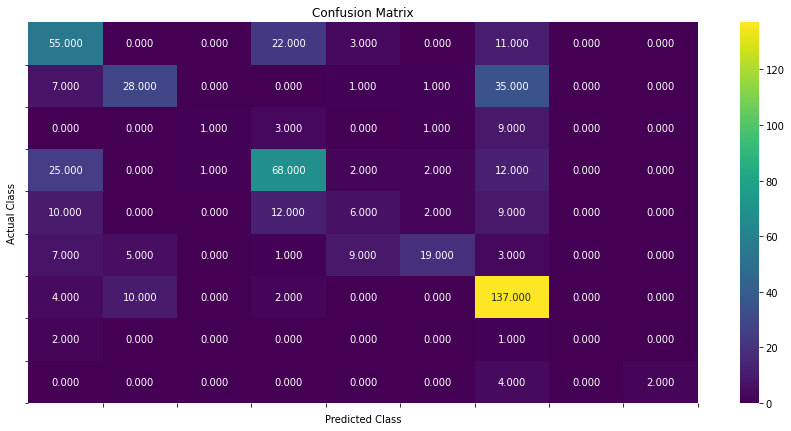

------------------------------------------------------------------------------------------------------------------------
PRECISION MATRIX


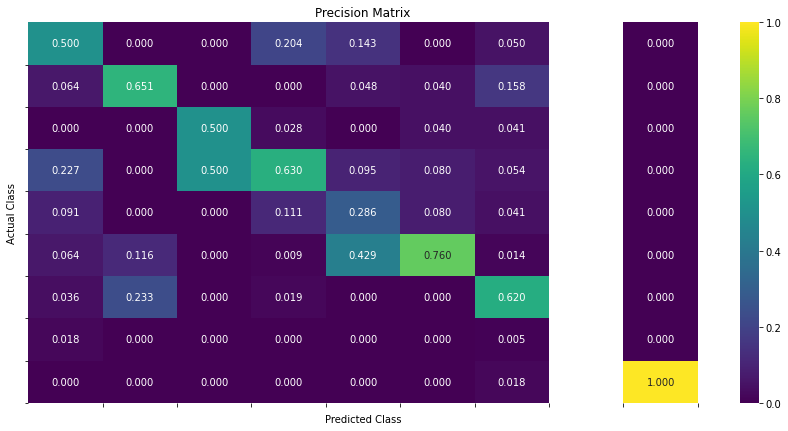

------------------------------------------------------------------------------------------------------------------------
RECALL MATRIX


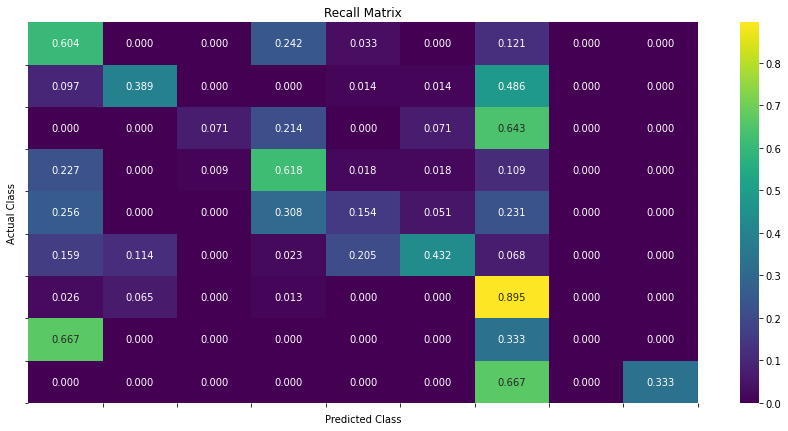

In [73]:
# plotting the confusion matrix
plot_conf_mat(y_valid, clf.predict(X_valid_onehot), labels=list(range(1, 10)))

### Stacking The Models

In [19]:
# Creating the different models

# logistic regression
clf1 = SGDClassifier(alpha=0.001, penalty="l2", loss="log", class_weight="balanced", random_state=42)
clf1.fit(X_train_onehot, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

# SVM
clf2 = SGDClassifier(alpha=1, penalty="l2", loss="hinge", class_weight="balanced", random_state=42)
clf2.fit(X_train_onehot, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

# Naive Bayes
clf3 = MultinomialNB(alpha=0.001)
clf3.fit(X_train_onehot, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

In [20]:
# Fitting the Calibrated Models and printing logloss
sig_clf1.fit(X_train_onehot, y_train)
print(f"Logistic Regression, Log Loss: {log_loss(y_valid, sig_clf1.predict_proba(X_valid_onehot)):.2f}")

sig_clf2.fit(X_train_onehot, y_train)
print(f"Support Vector Machine, Log Loss: {log_loss(y_valid, sig_clf2.predict_proba(X_valid_onehot)):.2f}")

sig_clf3.fit(X_train_onehot, y_train)
print(f"Naive Bayes, Log Loss: {log_loss(y_valid, sig_clf3.predict_proba(X_valid_onehot)):.2f}")

Logistic Regression, Log Loss: 1.00
Support Vector Machine, Log Loss: 1.21
Naive Bayes, Log Loss: 1.26


In [26]:
# Training the Stacking Classifier, Hyperparameter tuning

alphas = [0.0001,0.001,0.01,0.1,1,10]

for alpha in alphas:
    lr = LogisticRegression(C = alpha)
    clf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3],
                            meta_classifier=lr,
                            use_probas=True)
    
    clf.fit(X_train_onehot, y_train)
    print(f"For Alpha {alpha}, Log Loss: {log_loss(y_valid, clf.predict_proba(X_valid_onehot)):.4f}")

For Alpha 0.0001, Log Loss: 1.8166
For Alpha 0.001, Log Loss: 1.7094
For Alpha 0.01, Log Loss: 1.2984
For Alpha 0.1, Log Loss: 1.1102
For Alpha 1, Log Loss: 1.2802
For Alpha 10, Log Loss: 1.5616


In [27]:
# Testing the stacking model with the best hyperparameter
lr = LogisticRegression(C = 0.1)
clf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3],
                        meta_classifier=lr,
                        use_probas=True)
clf.fit(X_train_onehot, y_train)

StackingClassifier(classifiers=[CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001,
                                                                                    class_weight='balanced',
                                                                                    loss='log',
                                                                                    random_state=42)),
                                CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1,
                                                                                    class_weight='balanced',
                                                                                    random_state=42)),
                                CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=0.001))],
                   meta_classifier=LogisticRegression(C=0.1), use_probas=True)

In [28]:
# Errors:
print(f"Training Error: {log_loss(y_train, clf.predict_proba(X_train_onehot)):.4f}")
print(f"Validation Error: {log_loss(y_valid, clf.predict_proba(X_valid_onehot)):.4f}")
print(f"Testing Error: {log_loss(y_test, clf.predict_proba(X_test_onehot)):.4f}")

Training Error: 0.4771
Validation Error: 1.1102
Testing Error: 1.2611


CONFUSION MATRIX


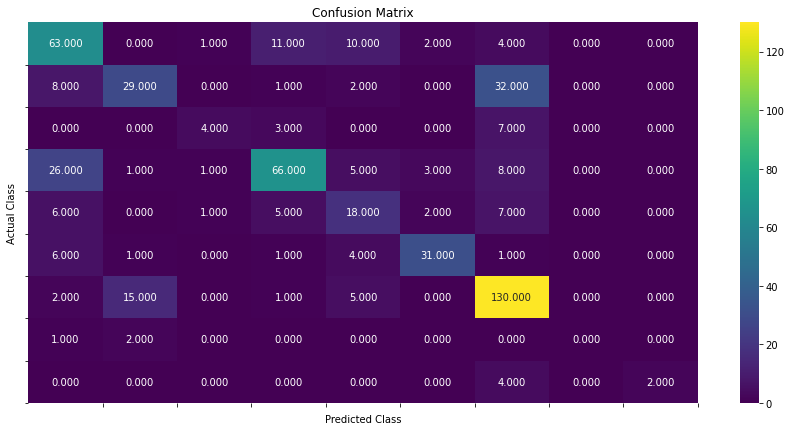

------------------------------------------------------------------------------------------------------------------------
PRECISION MATRIX


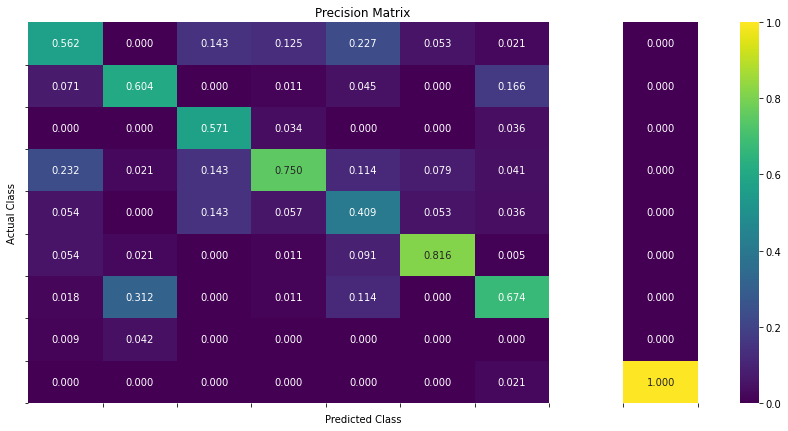

------------------------------------------------------------------------------------------------------------------------
RECALL MATRIX


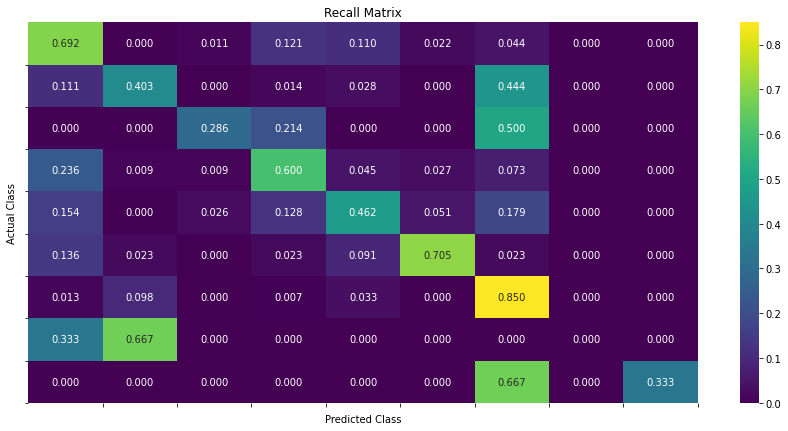

In [31]:
# Plotting the confusion matrix:
plot_conf_mat(y_valid, clf.predict(X_valid_onehot), labels=list(range(1, 10)))

## Majority Voting Classifier

In [32]:
# building the classifier
voting_clf = VotingClassifier(estimators=[('lr', sig_clf1), ('svm', sig_clf2), ('mnb', sig_clf3)], voting='soft')

# fitting the data to the voting classifier
voting_clf.fit(X_train_onehot, y_train)

VotingClassifier(estimators=[('lr',
                              CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001,
                                                                                  class_weight='balanced',
                                                                                  loss='log',
                                                                                  random_state=42))),
                             ('svm',
                              CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1,
                                                                                  class_weight='balanced',
                                                                                  random_state=42))),
                             ('mnb',
                              CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=0.001)))],
                 voting='soft')

In [33]:
# Testing the model's performance on all sets
print(f"Training Error: {log_loss(y_train, voting_clf.predict_proba(X_train_onehot)):.4f}")
print(f"Validation Error: {log_loss(y_valid, voting_clf.predict_proba(X_valid_onehot)):.4f}")
print(f"Testing Error: {log_loss(y_test, voting_clf.predict_proba(X_test_onehot)):.4f}")

Training Error: 0.7262
Validation Error: 1.0909
Testing Error: 1.2214


CONFUSION MATRIX


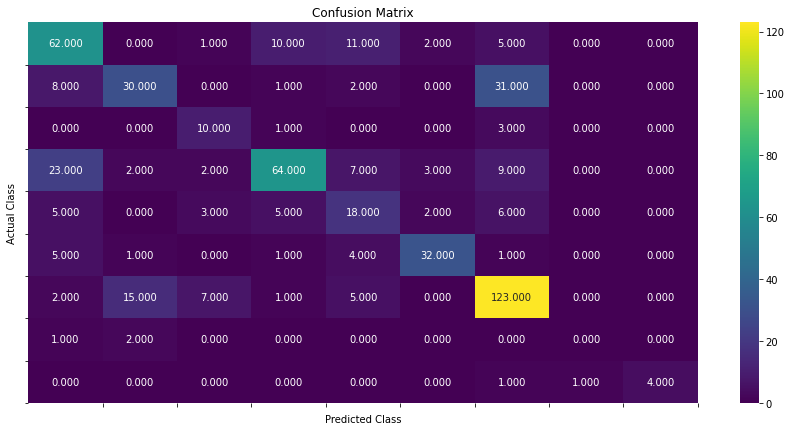

------------------------------------------------------------------------------------------------------------------------
PRECISION MATRIX


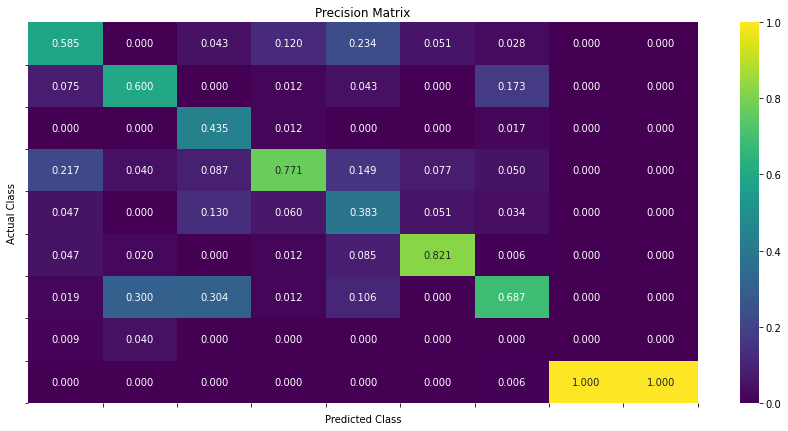

------------------------------------------------------------------------------------------------------------------------
RECALL MATRIX


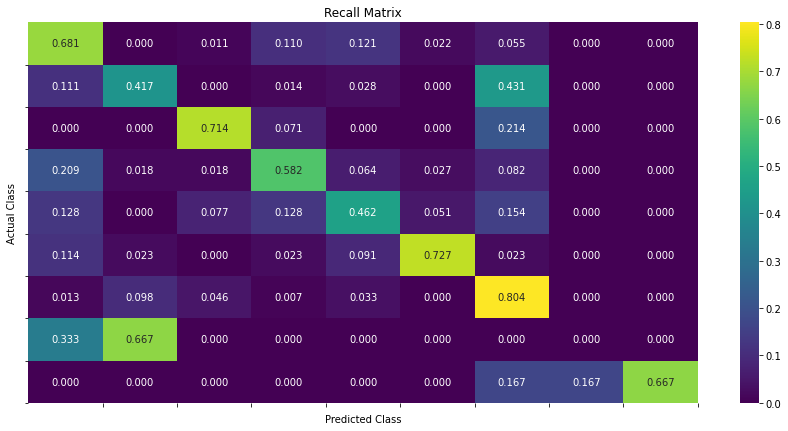

In [34]:
# plotting the confusion matrix
plot_conf_mat(y_valid, voting_clf.predict(X_valid_onehot), labels=list(range(1, 10)))